# Comparing results with baseline and chance level

In this notebook, we present how to compare the statistical performance of a
model to a minimal baseline.

Indeed, in the previous notebook, we compared the testing error by
taking into account the target distribution. A good practice is to compare
the testing error with a dummy baseline and the chance level. In
regression, we could use the `DummyRegressor` and predict the mean target
without using the data. The chance level can be determined by permuting the
labels and check the difference of result.

Therefore, we will conduct experiment to get the score of a model and the two
baselines. We will start by loading the California housing dataset.

In [9]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

Across all evaluations, we will use a `ShuffleSplit` cross-validation.

In [10]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

We will start by running the cross-validation for the decision tree
regressor which is our model of interest. Besides, we will store the
testing error in a pandas series.

In [11]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
result_regressor = cross_validate(regressor, data, target,
                                  cv=cv, scoring="neg_mean_absolute_error",
                                  n_jobs=2)

errors_regressor = pd.Series(-result_regressor["test_score"],
                             name="Regressor error")

Then, we will evaluate our first baseline. This baseline is called a dummy
regressor. This dummy regressor will always predict the mean target computed
on the training. Therefore, the dummy regressor will never use any
information regarding the data `data`.

In [12]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
result_dummy = cross_validate(dummy, data, target,
                              cv=cv, scoring="neg_mean_absolute_error",
                              n_jobs=2)
errors_dummy = pd.Series(-result_dummy["test_score"], name="Dummy error")

Finally, we will evaluate the statistical performance of the second baseline.
This baseline will provide the statistical performance of the chance level.
Indeed, we will train a decision tree on some training data and evaluate the
same tree on data where the target vector has been randomized.

In [13]:
from sklearn.model_selection import permutation_test_score

regressor = DecisionTreeRegressor()
score, permutation_score, pvalue = permutation_test_score(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error",
    n_jobs=2, n_permutations=30)
errors_permutation = pd.Series(-permutation_score, name="Permuted error")

Finally, we plot the testing errors for the two baselines and the
actual regressor.

In [14]:
final_errors = pd.concat([errors_regressor, errors_dummy, errors_permutation],
                         axis=1)

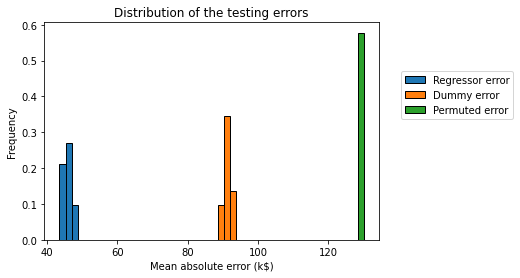

In [15]:
import matplotlib.pyplot as plt

final_errors.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

We see that even if the statistical performance of our model is far from
being good, it is better than the two baselines. Besides, we see that the
dummy regressor is better than a chance level regressor.

In practice, using a dummy regressor might be sufficient as a baseline.
Indeed, to obtain a reliable estimate the permutation of the target should
be repeated and thus this method is costly. However, it gives the true
chance level.